In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Definir la función que representa el sistema de ecuaciones diferenciales
def pendulum(t, y, L, g):
    theta, omega = y  # theta es el ángulo, omega es la velocidad angular
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return np.array([dtheta_dt, domega_dt])

In [20]:
import os
from tqdm.notebook import tnrange


def build_data(
    pendulums=100,
    data_filename="data/pendulum_10000.npy",
    t_resolution=100,
    y0=np.array([np.pi / 2, 0]),
    length_range=(0.1, 100),
    gravity_range=(0.1, 100),
    t_span=(0, 10),
):
    if os.path.exists(data_filename):
        return np.load(data_filename)

    t_eval = np.linspace(*t_span, t_resolution)
    results = np.empty((pendulums * t_resolution, 4))

    current_row = 0
    for _ in tnrange(pendulums):
        length = np.random.uniform(*length_range)
        gravity = np.random.uniform(*gravity_range)
        sol = solve_ivp(
            pendulum, t_span, y0, t_eval=t_eval, args=(length, gravity), vectorized=True
        )

        length_array = np.full_like(sol.t, length)
        gravity_array = np.full_like(sol.t, gravity)

        result_chunk = np.vstack([sol.t, length_array, gravity_array, sol.y[0]]).T
        chunk_size = t_resolution
        results[current_row : current_row + chunk_size] = result_chunk
        current_row += chunk_size

    return results

In [21]:
pendulums = 10000
data_filename = f"data/pendulum_{pendulums}.npy"
t_resolution = 100

In [22]:
results = build_data(pendulums, data_filename, t_resolution)

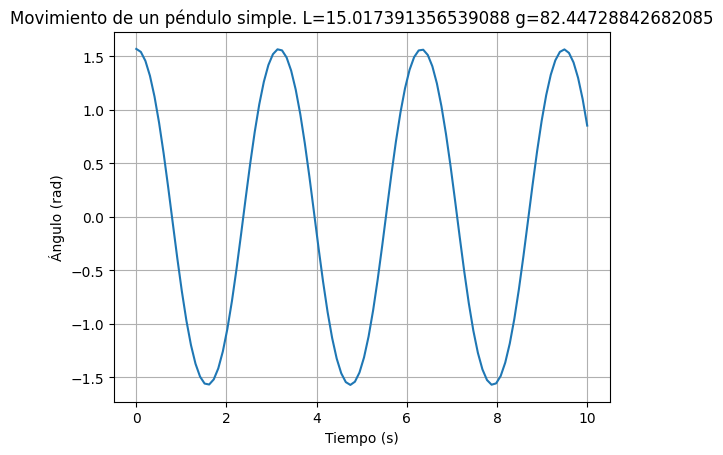

In [23]:
# Graficar los resultados para un péndulo simple
plt.plot(results[:t_resolution, 0], results[:t_resolution, 3])
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (rad)")
plt.title(f"Movimiento de un péndulo simple. L={results[0, 1]} g={results[0, 2]}")
plt.grid(True)
plt.show()

np.save(data_filename, results)

In [24]:
data = np.load(data_filename)
print(data.shape)

(1000000, 4)


In [49]:
model_rows = 10000
model_data = np.random.permutation(data)[:model_rows]

X = model_data[:, :3]
y = model_data[:, 3]

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Dividir en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_normalized, test_size=0.2, random_state=42
)

In [51]:
# Creamos la FFNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(3,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1))

model.compile(
    optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["root_mean_squared_error"]
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from datetime import datetime

epochs = 1000
history = model.fit(
    X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=False
)
now = datetime.now().isoformat()
model_name = f"{now}_pendulum_tim{t_resolution}_epo{epochs}_row{len(X)}"
model.save(f"models/{model_name}.keras")
np.save(f"history/{model_name}.npy", history.history)

In [53]:
from tensorflow.keras.saving import load_model

model = load_model(
    "models/2024-05-19T20:19:36.964815_pendulum_tim100_epo100_row1000000.keras"
)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7898 - root_mean_squared_error: 0.8886  
Test Loss: [0.7841518521308899, 0.8855234980583191]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


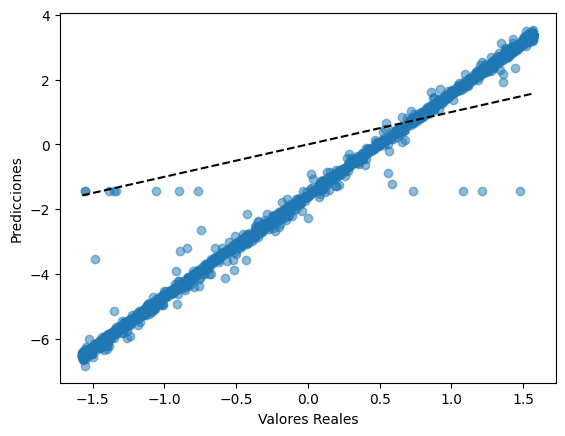

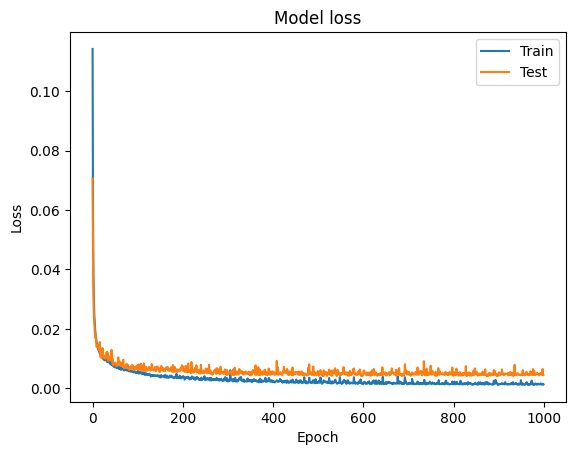

In [54]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Hacer predicciones
y_pred = model.predict(X_test)

# Desnormalizar las predicciones y los valores reales
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_denorm = scaler_y.inverse_transform(y_pred).flatten()

# Graficar las predicciones vs. los valores reales
plt.scatter(y_test_denorm, y_pred_denorm, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot(
    [y_test_denorm.min(), y_test_denorm.max()],
    [y_test_denorm.min(), y_test_denorm.max()],
    "k--",
)
plt.show()

# Graficamos el rendimiento del modelo
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


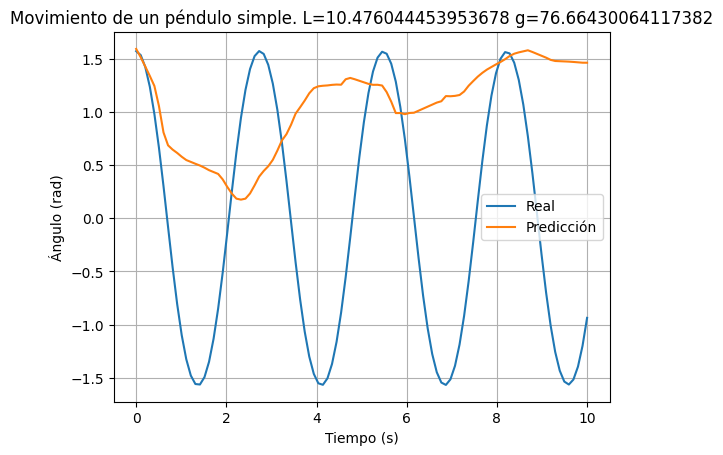

In [55]:
model = load_model(f"models/{model_name}.keras")
data = np.load(data_filename)

sample_index = np.random.randint(0, len(data) // t_resolution)
X_validate = data[sample_index * t_resolution : (sample_index + 1) * t_resolution, :3]
y_validate = data[sample_index * t_resolution : (sample_index + 1) * t_resolution, 3]

X_validate_normalized = scaler_X.fit_transform(X_validate)
y_predict = model.predict(X_validate_normalized)
y_predict_denorm = scaler_y.inverse_transform(y_predict).flatten()

plt.plot(X_validate[:, 0], y_validate)
plt.plot(X_validate[:, 0], y_predict_denorm)
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (rad)")
plt.legend(["Real", "Predicción"])
plt.title(f"Movimiento de un péndulo simple. L={X_validate[0, 1]} g={X_validate[0, 2]}")
plt.grid(True)
plt.show()

In [56]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def draw_pendulums(pendulums_data):
    lengths_data, angles_data = pendulums_data[:, 0], pendulums_data[:, 1]
    longest_length = np.max(lengths_data[:])

    # Crear la figura y el eje
    fig, ax = plt.subplots()
    ax.set_xlim(-longest_length - 0.5, longest_length + 0.5)
    ax.set_ylim(-longest_length - 0.5, longest_length + 0.5)
    ax.set_aspect("equal")
    ax.grid(True)

    # Crear líneas que representarán los péndulos
    lines = [ax.plot([], [], "o-", lw=2)[0] for _ in pendulums_data]

    # Función de inicialización
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # Función de actualización para la animación
    def update(t):
        theta = angles_data[:, t]
        L = lengths_data[:, t]
        x = L * np.sin(theta)
        y = -L * np.cos(theta)
        for i, line in enumerate(lines):
            line.set_data([0, x[i]], [0, y[i]])
        return lines

    # Crear la animación
    ani = FuncAnimation(
        fig, update, frames=t_resolution, init_func=init, blit=True, interval=30
    )

    # Mostrar la animación en el notebook
    return HTML(ani.to_jshtml())

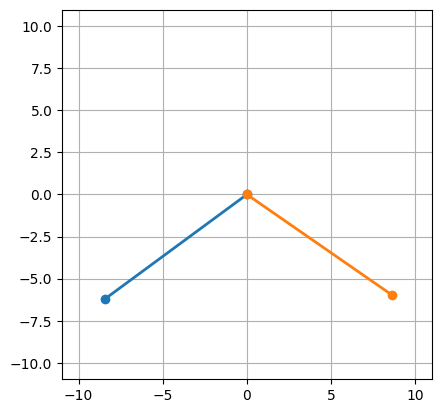

In [57]:
X_draw = X_validate[:, 1]

pendulums_data = np.array([[X_draw, y_validate], [X_draw, y_predict[:, 0]]])
draw_pendulums(pendulums_data)